# BEE 4750: Final Project

Members: Jonathan Marcuse (jrm564), Geovany Rodriguez (ga283), Oliver Sandiford (ots22)

In [55]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/Desktop/Final Projects/4750_Project`


In [56]:
#initiating several packages that may be useful later
Pkg.add("Plots")
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("Dates")
Pkg.add("Distributions")
using Plots
using CSV
using DataFrames
using Dates
using Distributions

   Resolving package versions...


  No Changes to `~/Desktop/Final Projects/4750_Project/Project.toml`
  No Changes to `~/Desktop/Final Projects/4750_Project/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Desktop/Final Projects/4750_Project/Project.toml`
  No Changes to `~/Desktop/Final Projects/4750_Project/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Desktop/Final Projects/4750_Project/Project.toml`
  No Changes to `~/Desktop/Final Projects/4750_Project/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Desktop/Final Projects/4750_Project/Project.toml`
  No Changes to `~/Desktop/Final Projects/4750_Project/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Desktop/Final Projects/4750_Project/Project.toml`
  No Changes to `~/Desktop/Final Projects/4750_Project/Manifest.toml`


---

### Create A Distribution of All Planes

The following makes a distribution of all planes depending on the proportion of planes that are of different sizes in the total fleet. We organized all of the different plane types into 5 different categories depending on landing speed which is a linear interpolation between 130 and 160 knots and then found the proportion of the total that was each type of aircraft.

In [57]:
#value is the speed of the selected aircraft as this is what is relevance 
    #for wake calculations
aircraft_landing_speeds = [130, 137.5, 145, 152.5, 160];

#proportions of each tye of aircraft
proportions = [0.101333333, 0.248, 0.242666667, 0.370666667, 0.037333333];

#Creating the distribution of plane types to select from
plane_dist = Categorical(proportions);

Categorical{Float64, Vector{Float64}}(
support: Base.OneTo(5)
p: [0.101333333, 0.248, 0.242666667, 0.370666667, 0.037333333]
)


### Create function to find separation time between two types of aircrafts

This calculates the necessary separation between two planes with respect to air wake and ATS safety standards given the landing speeds of the aircraft and runway length.

In [58]:
function wake_time(plane1_speed,plane2_speed,min_spacing,runway_length)
    Time_Space = plane1_speed > plane2_speed ? 
    ((min_spacing/plane1_speed)*3600) : 
    (((min_spacing/plane1_speed)+(runway_length/plane1_speed)
    -(runway_length/plane2_speed))*3600);
    return Time_Space
end

wake_time (generic function with 1 method)

---

### Monte Carlo Iteration of EWR Air Traffic Model

The plane landing selection per iteration is a random draw from the planes distribution defined earlier, so Monte Carlo with 5000 iterations is used to arrive at a mean that minimizes the effects of the randomization.

In [59]:
 #initialize vector to count total days for each Monte Carlo iteration
days = zeros(5000);

#initialize plane counting vector
count = zeros(5000,44640,3); 
#For dimension 1: it is the Monte Carlo iteration for this data; 
#For dimension 2: it is the minutes since the start of the week; 
#For the 3rd dimension: element 1 will be aircrafts landed on runway 1,
    #element 2 for runway 2, and element 3 for takeoffs on runway 3

for j in 1:5000

    tot_planes_per_month = 35867; #planes per month
    min_spacing = 2.5; #nautical miles 
        #(safety parameter for distance between aircrafts in air)
    runway1_length = (10000/6076.11549); #nautical miles for runway 1
    runway2_length = (6800/6076.11549); #nautical miles for runway 2
    runway3_length = (11000/6076.11549); #nautical miles for runway 3
    t = zeros(Float64, 3); #initial time at beginning of iteration 
        #where position 1 is a tracker of time related to runway 1, 
        #position 2 for arrivals on runway 2 
        #and position 3 for departures in runway 3
    i=1; #initialize iteration stepper

    full_gates = 72; #60% of 121 gates full initially

    #Select the first plane that will land on runway 1
    selected_plane = rand(plane_dist);
    last_runway1 = aircraft_landing_speeds[selected_plane] 

    #Select the first plane that will land on runway 2
    selected_plane = rand(plane_dist);
    last_runway2 = aircraft_landing_speeds[selected_plane] 

    #initialize vector to track all planes landed
    plane = zeros(tot_planes_per_month);
    plane[i] = last_runway1;
    i=i+1;
    plane[i] = last_runway2;

    #Assume first planes land at time t=0 on the first and second runway

    while full_gates <=121 && i<=tot_planes_per_month-1 
    #loop fails if gate capacity fills and terminates when all planes land
        
        i = i+1 #iterate plane number of the month

        #randomy select which plane lands next
        selected_plane = rand(plane_dist);
        plane[i] = aircraft_landing_speeds[selected_plane];

        #If statement to choose which of the 2 landing runways the chosen 
            #plane will land on. It will choose the runway that 
            #hasn't been landed on for longer
        if t[1]<=t[2] #runway 1 chosen

            #Calculate the wake time separation on runway 1
            landing_wake_time_separation = 
            (wake_time(plane[i],last_runway1,min_spacing,runway1_length));

            #time step of wake separation times
            t[1] = t[1]+landing_wake_time_separation; 

            full_gates = full_gates+1; #one new plane at the gate
            chosen_runway = 1;
            #Track which plane was now the last to land on runway 1
            last_runway1 = plane[i]; 

            #Count plane landinds at current minute on runway 1
            count[j,Int(floor(t[1]/60))+1,1] = 
            count[j,Int(floor(t[1]/60))+1,1]+1;
                #index at the time in minutes and the +1 is so that it 
                #doesn't access the count vector at position 0

        else #runway 2 chosen

            #Calculate the wake time separation on runway 2
            landing_wake_time_separation = 
            (wake_time(plane[i],last_runway2,min_spacing,runway2_length));

            #time step of wake separation times
            t[2] = t[2]+landing_wake_time_separation; 

            full_gates = full_gates+1; #one new plane at the gate
            chosen_runway = 2;
            last_runway2 = plane[i];
            #Track which plane was now the last to land on runway 2

            #Count plane landinds at current minute on runway 1
            count[j,Int(floor(t[2]/60))+1,2] = 
            count[j,Int(floor(t[2]/60))+1,2]+1;
        end

        #time delays after landing
        deplane_and_boarding = 60*60+16.7*60; 
            #60 minutes per plane to board and deplane 
            #and 16.7 min for taxi
        takeoff_wake_time_separation = 
        wake_time(plane[i],plane[i-1],min_spacing,runway3_length); 
            #plane order the same because the first plane to land will 
            #be the first to take off
                #aircrafts pooled in the same vector here bc it doesnt 
                #matter if they landed on runway 1 or 2, 
                #they all take off from runway 3
        #amount of time for each gate to be ready to fly another plane
        time_for_departure = 
        max(takeoff_wake_time_separation,deplane_and_boarding/full_gates); 
            #either the wake time or plane turn around+taxi will be the 
            #constraint on departure, whichever is longer
        
        if chosen_runway == 1
            #A departure has occured since the last arrival
            if t[1]-t[3]>=time_for_departure 

                #calculate total departures since the last arrival
                departures = floor((t[1]-t[3])/time_for_departure);

                #subtract number of full gates
                full_gates = full_gates-departures; 

                #additional time iteration for departures
                t[3] = t[3]+time_for_departure*departures; 
                
                #count departures at current minute
                count[j,Int(floor(t[3]/60))+1,3] = 
                count[j,Int(floor(t[3]/60))+1,3]+departures;

            #No departure since last arrival and gates are all full
            elseif t[1]-t[3]<time_for_departure && full_gates==121 

                #time step increase to have arrivals delayed 
                #until gate space is open
                t[1] = t[3]+time_for_departure; 
                #increase time step for runway 3 because 
                #another plane has taken off
                t[3] = t[3]+time_for_departure;

                full_gates = full_gates-1; #subtract number of full gates

                #count departures at current minute
                count[j,Int(floor(t[3]/60))+1,3] = 
                count[j,Int(floor(t[3]/60))+1,3]+1;
            end

        elseif chosen_runway == 2
            #A departure has occured since the last arrival
            if t[2]-t[3]>=time_for_departure 

                #calculate total departures since the last arrival
                departures = floor((t[2]-t[3])/time_for_departure);

                #subtract number of full gates
                full_gates = full_gates-departures; 

                #additional time iteration for departures
                t[3] = t[3]+time_for_departure*departures; 

                #count departures at current minute
                count[j,Int(floor(t[3]/60))+1,3] = 
                count[j,Int(floor(t[3]/60))+1,3]+departures;

            #No departure since last arrival and gates are all full 
            elseif t[2]-t[3]<time_for_departure && full_gates==121

                #time step increase to have arrivals delayed 
                #until gate space is open
                t[2] = t[3]+time_for_departure;
                #increase time step for runway 3 because 
                #another plane has taken off
                t[3] = t[3]+time_for_departure;

                #subtract number of full gates
                full_gates = full_gates-1; 

                #count departures at current minute
                count[j,Int(floor(t[3]/60))+1,3] = 
                count[j,Int(floor(t[3]/60))+1,3]+1;
            end
        end
    end

    days[j] = max(t[1],t[2],t[3])/86400; 
    #the longest of the 3 time trackers will be the total time 
    #(units converted to days)
end

#flatten the count matrix to average across all Monte Carlo iterations
plane_tracker = zeros(44640,3);
for i in 1:44640
    for j in 1:3
        plane_tracker[i,j] = mean(count[:,i,j]);
    end
end

println("It will take $(round(sum(days)/length(days),digits=4)) 
days for all 35867 planes to land and depart
compared to the 31 days for 35867 planes to 
land and depart under normal opertations")

It will take 26.4056 
days for all 35867 planes to land and depart
compared to the 31 days for 35867 planes to 
land and depart under normal opertations


Assumptions made in the above:
- starting gate capacity will be 72 out of 121, but for the majority of the rest of the week it will run at full capacity
- total time between takeoffs will be the wake time separation between aircrafts OR the waiting time for deplane, boarding and taxi divided by the total number of gates which gives you the total time in between filled gates with planes ready to depart: whichever of these 2 is greatest will be used
- total time between landings will be the wake separation equation because it also includes length of the runway parameter to ensure it is cleared before the next landing
- Not really an assumption but an added explanation to the above code: The takeoffs and landings must be coordinated such that the total number of grounded planes filling gates is not exceeded which is why we have the if statements for additional time steps

### Creating a vector of cumulative total planes landed every minute per runway

In [60]:
#Create cumulative planes landed per runway vector 
    #Done by taking the cumulative sum of the count vector

cumulative_count = zeros(5000,44640,3);

for j in 1:5000
    for k in 1:3
        cumulative_count[j,:,k] = cumsum(count[j,:,k]);
    end
end

#Flatten the cumulative count vector across all Monte Carlo iterations
plane_tracker = zeros(44640,3);

for i in 1:44640
    for j in 1:3
        plane_tracker[i,j] = mean(cumulative_count[:,i,j]);
    end
end

#Find what the length of the vector should be
    #Should end once all flights have landed
xmax = Int(ceil((sum(days)/length(days))*(60*24))); 
    #convert to minutes and nearest integer

38025

### Plotting a snippet of the first iteration of the airport traffic model

Now we will graph aircrafts landed versus time for each landing runway, and aircrafts taken off versus time for the takeoff runway. This will be done using just one iteration of the model rather than the enitre Monte Carlo iteration. (Maybe later can figure out a way to do average landed per given time interval step across all monte carlo iterations)

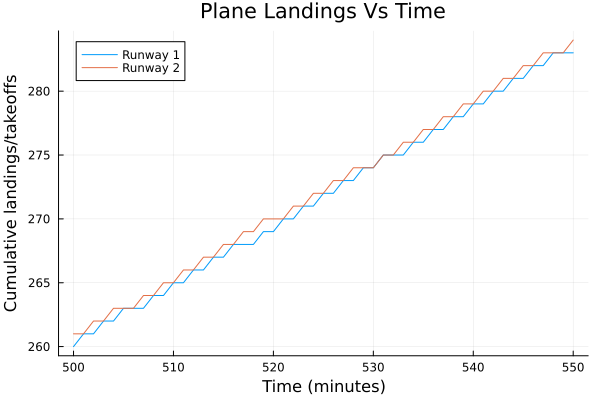

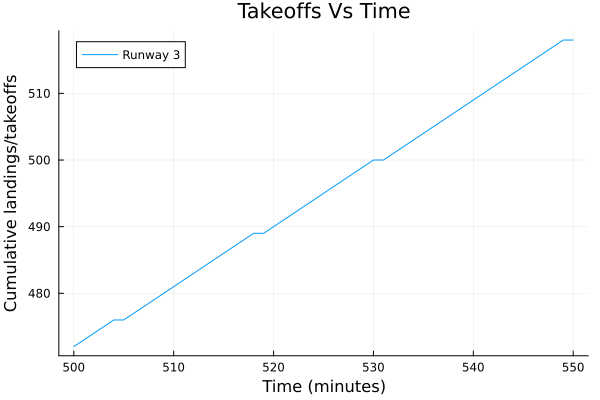

In [61]:
#Snippet upper and lower bound x range (minutes)
LB = 500;
UB = 550;

#Create vectors of y-values to plot for each runway
y_runway_1 = cumulative_count[1,LB:UB, 1];
y_runway_2 = cumulative_count[1,LB:UB, 2];
y_runway_3 = cumulative_count[1,LB:UB, 3];

#Plot the landing runways
p1 = plot(LB:UB, y_runway_1, label="Runway 1", 
xlabel="Time (minutes)", ylabel="Cumulative landings/takeoffs", 
title="Plane Landings Vs Time")
plot!(p1,LB:UB, y_runway_2, label="Runway 2")

#Plot the takeoff runway
p2 = plot(LB:UB, y_runway_3, label="Runway 3", 
xlabel="Time (minutes)", ylabel="Cumulative landings/takeoffs", 
title="Takeoffs Vs Time")

display(p1)
display(p2)


### Plotting the Monte Carlo trends for 5 days

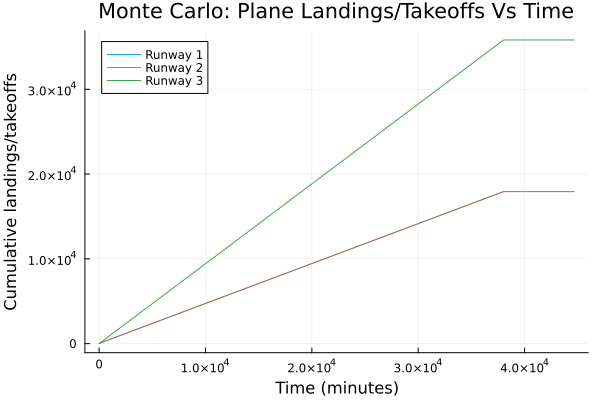

In [62]:
#Plot the entire range of the cumulative plane landing counts 
#averaged across all Monte Carlo iterations
plot(1:44640, plane_tracker[:,1], label="Runway 1", xlabel="Time (minutes)", 
ylabel="Cumulative landings/takeoffs",
title="Monte Carlo: Plane Landings/Takeoffs Vs Time")
plot!(1:44640, plane_tracker[:,2], label="Runway 2")
plot!(1:44640, plane_tracker[:,3], label="Runway 3")

### Plotting the Monte Carlo trends for the duration to land 8621 aircrafts

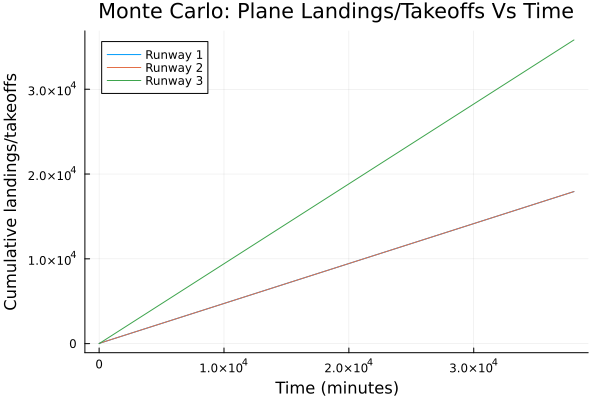

In [63]:
#Plot the range where planes are still landing 
#of the cumulative plane landing counts 
#averaged across all Monte Carlo iterations
y_runway_1 = plane_tracker[1:xmax, 1];
y_runway_2 = plane_tracker[1:xmax, 2];
y_runway_3 = plane_tracker[1:xmax, 3];

plot(1:xmax, y_runway_1, label="Runway 1", 
xlabel="Time (minutes)", ylabel="Cumulative landings/takeoffs",
title="Monte Carlo: Plane Landings/Takeoffs Vs Time")
plot!(1:xmax, y_runway_2, label="Runway 2")
plot!(1:xmax, y_runway_3, label="Runway 3")

---

### Load in Wind Speed Data
This has the wind speeds at Newark for every 6 minutes of the month of August in 2023. This will be used to tell us how much to delay flights by given the wind speed. Based on our background research, if the wind speed is above 30mph the aircraft will be delayed by 30 minutes. If the wind speed is under 30mph after the 30 min it is clear for takeoff, if not there will be another 30 minute delay.

In [64]:
# Load the CSV file into a DataFrame
Wind_DataFrame = DataFrame(CSV.File("Wind_Data.csv"));

# Extract wind speed and date columns
wind_speed = Wind_DataFrame."Wind Speed (mph)";

Next we find the total number of minutes delayed for the month

In [66]:
#initialize index i at 1
i = 1;
#initialize total delay time at 0 minutes
delay = 0;

while i<length(wind_speed)
    if wind_speed[i]>=30
        delay = delay+30;
        i = i+5; #jump 5 indexes (or 30 min) ahead to continue scanning
    else
        i = i+1 #scan at next index
    end
end

println("The total delay will be $delay minutes 
which increases the total days to complete the landing 
of all aircrafts from $(round(sum(days)/length(days),digits=4)) days 
to $((round(sum(days)/length(days),digits=4))+(delay/1440)) days")

The total delay will be 180 minutes 
which increases the total days to complete the landing 
of all aircrafts from 26.4056 days 
to 26.5306 days


### Calculate the total time saved with this model

In [74]:
days_to_complete = sum(days)/length(days)+(delay/1440);

time_saved = 31-days_to_complete;

percent_time_saved = (time_saved/31)*100;

println("This model saved a total of $(round(time_saved,digits=4)) days 
in the month, which is a $(round(percent_time_saved,digits=2))% reduction 
in total time.")

This model saved a total of 4.4694 days in the month, 
which is a 14.42% reduction in total time.
